In [1]:
from skimage import data
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
import numpy as np
from enum import IntEnum
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
from skimage.draw import polygon_perimeter

In [2]:
class Directions(IntEnum):
    NORTH = 0
    EAST = 1
    SOUTH = 2
    WEST = 3


NORTH = Directions.NORTH
EAST = Directions.EAST
SOUTH = Directions.SOUTH
WEST = Directions.WEST

def trace_boundary(image):
    padded_img = np.pad(image, 1)

    img = padded_img[1:-1, 1:-1]
    img_north = padded_img[:-2, 1:-1]
    img_south = padded_img[2:, 1:-1]
    img_east = padded_img[1:-1, 2:]
    img_west = padded_img[1:-1, :-2]

    border = np.zeros((4, *padded_img.shape), dtype=np.intp)

    border[NORTH][1:-1, 1:-1] = (img == 1) & (img_north == 0)
    border[EAST][1:-1, 1:-1] = (img == 1) & (img_east == 0)
    border[SOUTH][1:-1, 1:-1] = (img == 1) & (img_south == 0)
    border[WEST][1:-1, 1:-1] = (img == 1) & (img_west == 0)

    adjacent = np.zeros((4, *image.shape), dtype=np.intp)
    adjacent[NORTH] = np.argmax(np.stack(
        (border[WEST][:-2, 2:],
         border[NORTH][1:-1, 2:],
         border[EAST][1:-1, 1:-1])
    ), axis=0)
    adjacent[EAST] = np.argmax(np.stack(
        (border[NORTH][2:, 2:],
         border[EAST][2:, 1:-1],
         border[SOUTH][1:-1, 1:-1])
    ), axis=0)
    adjacent[SOUTH] = np.argmax(np.stack(
        (border[EAST][2:, :-2],
         border[SOUTH][1:-1, :-2],
         border[WEST][1:-1, 1:-1])
    ), axis=0)
    adjacent[WEST] = np.argmax(np.stack(
        (border[SOUTH][:-2, :-2],
         border[WEST][:-2, 1:-1],
         border[NORTH][1:-1, 1:-1])
    ), axis=0)

    directions = np.zeros((len(Directions), *image.shape, 3, 3), dtype=np.intp)
    directions[NORTH][..., :] = [(3, -1, 1), (0, 0, 1), (1, 0, 0)]
    directions[EAST][..., :] = [(-1, 1, 1), (0, 1, 0), (1, 0, 0)]
    directions[SOUTH][..., :] = [(-1, 1, -1), (0, 0, -1), (1, 0, 0)]
    directions[WEST][..., :] = [(-1, -1, -1), (0, -1, 0), (-3, 0, 0)]

    proceding_edge = directions[
        np.arange(len(Directions))[:, np.newaxis, np.newaxis],
        np.arange(image.shape[0])[np.newaxis, :, np.newaxis],
        np.arange(image.shape[1])[np.newaxis, np.newaxis, :],
        adjacent
    ]

    unprocessed_border = border[:, 1:-1, 1:-1].copy()
    borders = list()
    for start_pos in zip(*np.nonzero(unprocessed_border)):
        if not unprocessed_border[start_pos]:
            continue

        idx = len(borders)
        borders.append(list())
        start_arr = np.array(start_pos, dtype=np.intp)
        current_pos = start_arr
        while True:
            unprocessed_border[tuple(current_pos)] = 0
            borders[idx].append(tuple(current_pos[1:]))
            current_pos += proceding_edge[tuple(current_pos)]
            if np.all(current_pos == np.array(start_pos)):
                break

    # match np.nonzero style output
    border_pos = list()
    for border in borders:
        border = np.array(border)
        border_pos.append([border[:, 0], border[:, 1]])

    return border_pos

In [3]:
image = data.coins()[50:-50, 50:-50]
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(3))

In [4]:
borders = trace_boundary(bw)

In [5]:
img = np.stack([image] * 3, axis=-1)
for idx, border in enumerate(borders):
    # demonstrate that pixels are in order
    rr_bord, cc_bord = border
    rr, cc = polygon_perimeter(rr_bord, cc_bord)

    # rainbow *_*
    col_idx = idx * (1337 + 42000) % len(borders)

    color = np.array(cmap.gist_rainbow(1. * col_idx / len(borders))) * 255
    img[rr, cc, :] = color[:-1]

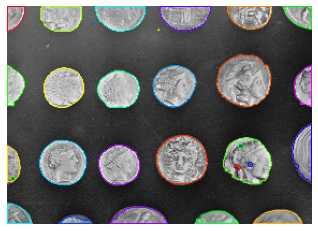

In [6]:
plt.imshow(img)
plt.gca().axis("off")
plt.show()